In [1]:
!git clone https://github.com/mwritescode/smart-contracts-vulnerabilities.git

fatal: destination path 'smart-contracts-vulnerabilities' already exists and is not an empty directory.


In [2]:
!pip install -r smart-contracts-vulnerabilities/requirements.txt

In [3]:
%cd smart-contracts-vulnerabilities/

/content/smart-contracts-vulnerabilities


In [4]:
import tqdm
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn.functional import normalize
from src.data.stats import GetMeanStd
from src.modeling.network.backbone import ResNet1D, ResNetModel
from src.data.transform import generate_signal_and_label, generate_image_and_label
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix

In [5]:
MAX_LEN = 16284
BATCH_SIZE = 8
DEVICE = 'cuda'
PATH = '../resnet_38epochs.pkl'

def img_label_to_tensor(examples):
    if 'image' in examples.keys():
        examples['image'] = [np.pad(img, pad_width=(0, MAX_LEN - len(img))) if len(img) < MAX_LEN else img[:MAX_LEN] for img in examples['image']]
        examples['image'] = [torch.unsqueeze(normalize(torch.tensor(img).float(), dim=0), dim=0) for img in examples['image']]

        examples['label'] = torch.tensor(examples['label'])
        return examples

In [6]:
test_ds = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='test', ignore_verifications=True)
test_ds = test_ds.filter(lambda elem: elem['bytecode'] != '0x')
test_ds = test_ds.map(generate_image_and_label, remove_columns=['address', 'source_code', 'bytecode', 'slither'])
test_ds.set_transform(img_label_to_tensor)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2096: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [7]:
img_size=224
# change test_ds to train
get_stats = GetMeanStd(test_ds, batch_size=16, img_size=img_size)
mean, std = get_stats()

img_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

padding_val = 0

Computing stats..: 100%|██████████| 996/996 [00:55<00:00, 17.80it/s]


In [8]:
def img_label_to_tensor(examples):
        if 'image' in examples.keys():
            examples['image'] = [img_transform(elem) for elem in examples['image']]

        if 'label' in examples.keys():
            examples['label'] = torch.tensor(examples['label'])
            return examples

In [9]:
test_ds.set_transform(img_label_to_tensor)

In [10]:
pos_weights = None

In [11]:
loader_test = DataLoader(test_ds,
                        batch_size=BATCH_SIZE)

In [12]:
model = ResNetModel(num_classes=5)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [14]:
total_preds = []
total_gt = []

with torch.no_grad():  # Disable gradient tracking during inference
    for batch in tqdm.tqdm(loader_test):
        images = batch['image'].to(DEVICE)
        preds = model(images)
        preds = (preds >= 0.0).float()  # Use torch operations directly
        total_preds.append(preds.cpu().numpy())
        total_gt.append(batch['label'].numpy())

y_pred = np.concatenate(total_preds, axis=0)
y_true = np.concatenate(total_gt, axis=0)

100%|██████████| 1991/1991 [00:48<00:00, 41.27it/s]


In [15]:
LABEL_NAMES = ['access-control', 'arithmetic', 'other', 'reentrancy', 'unchecked-calls']
print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, zero_division=0))

                 precision    recall  f1-score   support

 access-control       0.68      0.64      0.66      2331
     arithmetic       0.69      0.62      0.65      2708
          other       0.72      0.66      0.69      4193
     reentrancy       0.81      0.76      0.79      4838
unchecked-calls       0.88      0.81      0.84      7276

      micro avg       0.79      0.73      0.76     21346
      macro avg       0.76      0.70      0.73     21346
   weighted avg       0.79      0.73      0.76     21346
    samples avg       0.48      0.47      0.47     21346



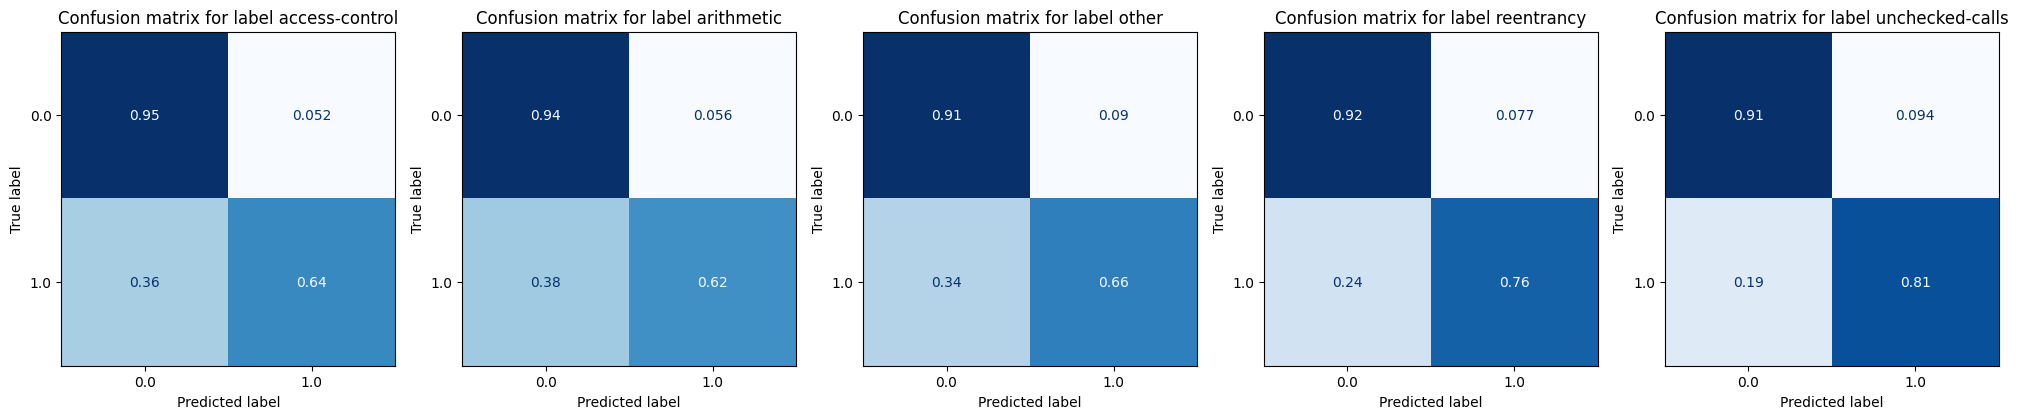

In [16]:
_, axs = plt.subplots(1, len(LABEL_NAMES), figsize=(25, 10))
conf_mat_dict={}

for label_col, ax in zip(range(len(LABEL_NAMES)), axs):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    ax.set_title("Confusion matrix for label " + LABEL_NAMES[label_col])
    ConfusionMatrixDisplay.from_predictions(y_true_label, y_pred_label, ax=ax, cmap=plt.cm.Blues, normalize='true', colorbar=False)

plt.show()